In [1]:
notebook_name = "68_鋳造製品_EfficientNet-B0_106.ipynb"
#MultiTaskEfficientNet_FPN
segmentation_class_weights = {0: 51, 1: 85, 2: 55, 3: 22, 4: 1, 5: 80, 6: 18}
# 0: 黒い点　1: 傷　2: 白いへこみ　3: 縁のへこみ　4: はね　5: 段上の傷　6: 複雑な中心が暗いへこみ
weight=2.0
# 交差検証

# インポート

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install albumentations
!pip install labelme
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Aug  7 10:57:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import sys
import os
import re
import random
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
%matplotlib inline

In [6]:
sys.path.append(os.path.abspath('/content/drive/Othercomputers/マイ パソコン/Defect_detection_in_cast_products/src'))

In [7]:
#print(sys.path)

In [8]:
from generate_annotation_masks_from_json import generate_annotation_masks_from_json
from generate_annotation_masked_images import generate_annotation_masked_images
from generate_multiclass_segmentation_masks_from_json import generate_multiclass_segmentation_masks_from_json
from load_and_preprocess_images_3 import load_and_preprocess_images
from plot_accuracy_precision_recall import plot_accuracy_precision_recall
from plot_confusion_matrix import plot_confusion_matrix
from plot_loss_curves import plot_loss_curves
from plot_roc_curve import plot_roc_curve
from path_config import *
from set_seed import set_seed
from train_one_fold import train_one_fold

  # 乱数seedの固定

In [9]:
set_seed(42)

# 各ワーカーのシード固定　DataLoaderの引数に渡す
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 乱数生成器
g = torch.Generator()
g.manual_seed(42)

# マスク作成

In [ ]:
generate_annotation_masks_from_json(ANNO_MASK_JSON_DIR, ANNO_MASK_DIR)
generate_annotation_masked_images(RAW_TRAIN_DIR, ANNO_MASK_DIR, ANNO_MASKED_IMAGES_DIR)
generate_multiclass_segmentation_masks_from_json(SEG_MASK_JSON_DIR, SEG_MASK_DIR)
generate_multiclass_segmentation_masked_images(RAW_TRAIN_DIR, SEG_MASK_DIR, SEG_MASKED_IMAGES_DIR)

In [11]:
# ファイル名のリスト取得
masked_images_filenames = list(SEG_MASKED_IMAGES_DIR.glob('*.jpeg'))

df = pd.read_csv(TRAIN_CSV)


# 前処理

In [12]:
# 前処理の定義
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(224, 224),
    A.ColorJitter(brightness=0.01, contrast=0.01, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [13]:
all_images, all_labels, all_seg_masks, all_image_paths = load_and_preprocess_images(df, transform, RAW_TRAIN_DIR, ANNO_MASKED_IMAGES_DIR, SEG_MASK_DIR, num_augmentations=20)

/content/drive/Othercomputers/マイ パソコン/Defect_detection_in_cast_products/src/load_and_preprocess_images_3.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seg_masks.append(torch.tensor(augmented['mask'], dtype=torch.long))


# 交差検証

In [14]:
print(len(all_images))
print(len(all_labels))
print(len(all_seg_masks))
print(len(all_image_paths))

5000
5000
5000
5000


In [15]:
print(all_seg_masks.shape)

torch.Size([5000, 224, 224])


In [16]:

# フォールドごとの損失と評価指標のログを保存するリスト
all_loss_train = []         # フォールドごとの、訓練データに対する損失
all_loss_val = []           # フォールドごとの、検証データに対する損失
all_accuracy_val = []       # フォールドごとの正解率
all_precision_val = []      # フォールドごとの適合率
all_recall_val = []         # フォールドごとの再現率
all_ground_truth_val = []   # フォールドごとの、各データに対する正解ラベル
all_predicted_val = []      # フォールドごとの、各データに対する予測ラベル
all_probabilities_val = []  # ROC曲線表示用

n_splits=5
num_epochs=50
batch_size=16
lr=1e-4
#weight=2.0
notebook_number = re.search(r'(\d+)', notebook_name).group(1)  # ファイル名からノートブック番号を抽出

for i in range(5):
    train_loss_per_epoch_history, record_loss_val_fold, record_accuracy_val_fold, record_precision_val_fold, record_recall_val_fold, current_predicted_val, current_ground_truth_val, current_probabilities_val = train_one_fold(all_images, all_labels, all_seg_masks, all_image_paths, notebook_number, n_splits, num_epochs, batch_size, lr, weight, desired_fold=i)

    # 損失と評価指標の履歴について、エポックごとの推移の記録を、フォールドごとに推移を記録するリストに追加する
    all_loss_train.append(train_loss_per_epoch_history)
    all_loss_val.append(record_loss_val_fold)
    all_accuracy_val.append(record_accuracy_val_fold)
    all_precision_val.append(record_precision_val_fold)
    all_recall_val.append(record_recall_val_fold)

    # 各フォールドの予測結果と正解ラベル　描画用
    all_predicted_val.append(current_predicted_val)
    all_ground_truth_val.append(current_ground_truth_val)
    all_probabilities_val.append(current_probabilities_val)


Fold 1/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 227MB/s]


MultiTaskEfficientNet_FPNモデルを初期化しました。


Fold 1 Epochs:   2%|▏         | 1/50 [00:31<25:41, 31.45s/it]

  Epoch: 1/50, Loss_Train: 11.3014, Loss_val: 1.4001, Accuracy_val: 0.9640, Precision_val: 0.9174, Recall_val: 1.0000


Fold 1 Epochs:   4%|▍         | 2/50 [01:00<24:10, 30.23s/it]

  Epoch: 2/50, Loss_Train: 2.0647, Loss_val: 0.8858, Accuracy_val: 0.9980, Precision_val: 0.9950, Recall_val: 1.0000


Fold 1 Epochs:   6%|▌         | 3/50 [01:30<23:25, 29.91s/it]

  Epoch: 3/50, Loss_Train: 1.3434, Loss_val: 0.6764, Accuracy_val: 0.9970, Precision_val: 0.9926, Recall_val: 1.0000


Fold 1 Epochs:   8%|▊         | 4/50 [02:00<22:55, 29.90s/it]

  Epoch: 4/50, Loss_Train: 1.0077, Loss_val: 0.5254, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  10%|█         | 5/50 [02:30<22:34, 30.10s/it]

  Epoch: 5/50, Loss_Train: 0.8094, Loss_val: 0.4111, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  12%|█▏        | 6/50 [03:01<22:08, 30.19s/it]

  Epoch: 6/50, Loss_Train: 0.6611, Loss_val: 0.3837, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  14%|█▍        | 7/50 [03:31<21:38, 30.19s/it]

  Epoch: 7/50, Loss_Train: 0.5670, Loss_val: 0.3373, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  16%|█▌        | 8/50 [04:01<21:10, 30.25s/it]

  Epoch: 8/50, Loss_Train: 0.5002, Loss_val: 0.3020, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  18%|█▊        | 9/50 [04:31<20:40, 30.26s/it]

  Epoch: 9/50, Loss_Train: 0.4473, Loss_val: 0.2914, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  20%|██        | 10/50 [05:02<20:10, 30.27s/it]

  Epoch: 10/50, Loss_Train: 0.4056, Loss_val: 0.2672, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  22%|██▏       | 11/50 [05:32<19:40, 30.28s/it]

  Epoch: 11/50, Loss_Train: 0.3836, Loss_val: 0.2487, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  24%|██▍       | 12/50 [06:02<19:11, 30.30s/it]

  Epoch: 12/50, Loss_Train: 0.3465, Loss_val: 0.2396, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  26%|██▌       | 13/50 [06:33<18:42, 30.33s/it]

  Epoch: 13/50, Loss_Train: 0.3276, Loss_val: 0.2033, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  28%|██▊       | 14/50 [07:03<18:12, 30.34s/it]

  Epoch: 14/50, Loss_Train: 0.3066, Loss_val: 0.2108, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  30%|███       | 15/50 [07:33<17:42, 30.35s/it]

  Epoch: 15/50, Loss_Train: 0.3043, Loss_val: 0.2003, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  32%|███▏      | 16/50 [08:04<17:11, 30.35s/it]

  Epoch: 16/50, Loss_Train: 0.2730, Loss_val: 0.1728, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  34%|███▍      | 17/50 [08:34<16:41, 30.35s/it]

  Epoch: 17/50, Loss_Train: 0.2693, Loss_val: 0.1855, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  36%|███▌      | 18/50 [09:04<16:10, 30.33s/it]

  Epoch: 18/50, Loss_Train: 0.2571, Loss_val: 0.1776, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  38%|███▊      | 19/50 [09:35<15:40, 30.33s/it]

  Epoch: 19/50, Loss_Train: 0.2508, Loss_val: 0.1655, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  40%|████      | 20/50 [10:05<15:08, 30.28s/it]

  Epoch: 20/50, Loss_Train: 0.2299, Loss_val: 0.1630, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  42%|████▏     | 21/50 [10:35<14:37, 30.25s/it]

  Epoch: 21/50, Loss_Train: 0.2317, Loss_val: 0.1628, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  44%|████▍     | 22/50 [11:05<14:06, 30.25s/it]

  Epoch: 22/50, Loss_Train: 0.2188, Loss_val: 0.1460, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  46%|████▌     | 23/50 [11:36<13:37, 30.27s/it]

  Epoch: 23/50, Loss_Train: 0.2101, Loss_val: 0.1412, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  48%|████▊     | 24/50 [12:06<13:07, 30.28s/it]

  Epoch: 24/50, Loss_Train: 0.2013, Loss_val: 0.1303, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  50%|█████     | 25/50 [12:36<12:37, 30.30s/it]

  Epoch: 25/50, Loss_Train: 0.1916, Loss_val: 0.1322, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  52%|█████▏    | 26/50 [13:07<12:07, 30.30s/it]

  Epoch: 26/50, Loss_Train: 0.1831, Loss_val: 0.1329, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  54%|█████▍    | 27/50 [13:37<11:36, 30.29s/it]

  Epoch: 27/50, Loss_Train: 0.1804, Loss_val: 0.1322, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  56%|█████▌    | 28/50 [14:07<11:06, 30.29s/it]

  Epoch: 28/50, Loss_Train: 0.1798, Loss_val: 0.1285, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  58%|█████▊    | 29/50 [14:37<10:35, 30.27s/it]

  Epoch: 29/50, Loss_Train: 0.1713, Loss_val: 0.1236, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  60%|██████    | 30/50 [15:08<10:04, 30.24s/it]

  Epoch: 30/50, Loss_Train: 0.1706, Loss_val: 0.1216, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  62%|██████▏   | 31/50 [15:38<09:34, 30.24s/it]

  Epoch: 31/50, Loss_Train: 0.1657, Loss_val: 0.1234, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  64%|██████▍   | 32/50 [16:08<09:03, 30.22s/it]

  Epoch: 32/50, Loss_Train: 0.1655, Loss_val: 0.1133, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  66%|██████▌   | 33/50 [16:38<08:33, 30.21s/it]

  Epoch: 33/50, Loss_Train: 0.1527, Loss_val: 0.1122, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  68%|██████▊   | 34/50 [17:08<08:03, 30.20s/it]

  Epoch: 34/50, Loss_Train: 0.1501, Loss_val: 0.1022, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  70%|███████   | 35/50 [17:39<07:32, 30.18s/it]

  Epoch: 35/50, Loss_Train: 0.1442, Loss_val: 0.0926, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  72%|███████▏  | 36/50 [18:09<07:02, 30.16s/it]

  Epoch: 36/50, Loss_Train: 0.1407, Loss_val: 0.1096, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  74%|███████▍  | 37/50 [18:39<06:32, 30.16s/it]

  Epoch: 37/50, Loss_Train: 0.1424, Loss_val: 0.0994, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  76%|███████▌  | 38/50 [19:09<06:02, 30.17s/it]

  Epoch: 38/50, Loss_Train: 0.1420, Loss_val: 0.0969, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  78%|███████▊  | 39/50 [19:39<05:31, 30.17s/it]

  Epoch: 39/50, Loss_Train: 0.1340, Loss_val: 0.1208, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  80%|████████  | 40/50 [20:09<05:01, 30.17s/it]

  Epoch: 40/50, Loss_Train: 0.1498, Loss_val: 0.1054, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  82%|████████▏ | 41/50 [20:39<04:31, 30.17s/it]

  Epoch: 41/50, Loss_Train: 0.1361, Loss_val: 0.0982, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  84%|████████▍ | 42/50 [21:10<04:01, 30.20s/it]

  Epoch: 42/50, Loss_Train: 0.1266, Loss_val: 0.0901, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  86%|████████▌ | 43/50 [21:40<03:31, 30.22s/it]

  Epoch: 43/50, Loss_Train: 0.1434, Loss_val: 0.1026, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  88%|████████▊ | 44/50 [22:10<03:01, 30.27s/it]

  Epoch: 44/50, Loss_Train: 0.1302, Loss_val: 0.0852, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  90%|█████████ | 45/50 [22:41<02:31, 30.32s/it]

  Epoch: 45/50, Loss_Train: 0.1223, Loss_val: 0.0973, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  92%|█████████▏| 46/50 [23:11<02:01, 30.34s/it]

  Epoch: 46/50, Loss_Train: 0.1183, Loss_val: 0.0884, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  94%|█████████▍| 47/50 [23:42<01:31, 30.36s/it]

  Epoch: 47/50, Loss_Train: 0.1150, Loss_val: 0.0877, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  96%|█████████▌| 48/50 [24:12<01:00, 30.39s/it]

  Epoch: 48/50, Loss_Train: 0.1171, Loss_val: 0.0867, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs:  98%|█████████▊| 49/50 [24:42<00:30, 30.38s/it]

  Epoch: 49/50, Loss_Train: 0.1158, Loss_val: 0.0928, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 1 Epochs: 100%|██████████| 50/50 [25:13<00:00, 30.27s/it]

  Epoch: 50/50, Loss_Train: 0.1165, Loss_val: 0.0851, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000
Fold 1の学習時間：1514.50秒



--- Fold 1 の誤分類された画像 ---
  誤分類された画像はありませんでした。
モデルを保存しました: /content/drive/Othercomputers/マイ パソコン/Defect_detection_in_cast_products/outputs/models/model_fold1_nb68.pth

交差検証ループ全体の実行時間 : 1518.08秒
学習・検証データを保存しました: outputs/predicted_labels/results_fold5_nb68.pkl
Fold 2/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskEfficientNet_FPNモデルを初期化しました。


Fold 2 Epochs:   2%|▏         | 1/50 [00:30<24:47, 30.36s/it]

  Epoch: 1/50, Loss_Train: 66.4957, Loss_val: 1.6258, Accuracy_val: 0.9200, Precision_val: 0.8347, Recall_val: 0.9975


Fold 2 Epochs:   4%|▍         | 2/50 [01:00<24:18, 30.38s/it]

  Epoch: 2/50, Loss_Train: 2.9227, Loss_val: 1.1424, Accuracy_val: 0.9670, Precision_val: 0.9277, Recall_val: 0.9950


Fold 2 Epochs:   6%|▌         | 3/50 [01:31<23:46, 30.34s/it]

  Epoch: 3/50, Loss_Train: 1.9881, Loss_val: 0.8940, Accuracy_val: 0.9900, Precision_val: 0.9756, Recall_val: 1.0000


Fold 2 Epochs:   8%|▊         | 4/50 [02:01<23:12, 30.28s/it]

  Epoch: 4/50, Loss_Train: 1.5184, Loss_val: 0.7262, Accuracy_val: 0.9970, Precision_val: 0.9926, Recall_val: 1.0000


Fold 2 Epochs:  10%|█         | 5/50 [02:31<22:44, 30.31s/it]

  Epoch: 5/50, Loss_Train: 1.2137, Loss_val: 0.6508, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  12%|█▏        | 6/50 [03:01<22:12, 30.29s/it]

  Epoch: 6/50, Loss_Train: 0.9863, Loss_val: 0.5157, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  14%|█▍        | 7/50 [03:32<21:42, 30.28s/it]

  Epoch: 7/50, Loss_Train: 0.8315, Loss_val: 0.4656, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  16%|█▌        | 8/50 [04:02<21:12, 30.30s/it]

  Epoch: 8/50, Loss_Train: 0.7152, Loss_val: 0.4028, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  18%|█▊        | 9/50 [04:32<20:42, 30.30s/it]

  Epoch: 9/50, Loss_Train: 0.6311, Loss_val: 0.3813, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  20%|██        | 10/50 [05:02<20:11, 30.28s/it]

  Epoch: 10/50, Loss_Train: 0.5711, Loss_val: 0.3206, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  22%|██▏       | 11/50 [05:33<19:41, 30.29s/it]

  Epoch: 11/50, Loss_Train: 0.5242, Loss_val: 0.3348, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  24%|██▍       | 12/50 [06:03<19:10, 30.28s/it]

  Epoch: 12/50, Loss_Train: 0.4853, Loss_val: 0.2759, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  26%|██▌       | 13/50 [06:33<18:40, 30.29s/it]

  Epoch: 13/50, Loss_Train: 0.4440, Loss_val: 0.2501, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  28%|██▊       | 14/50 [07:04<18:10, 30.29s/it]

  Epoch: 14/50, Loss_Train: 0.4138, Loss_val: 0.2442, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  30%|███       | 15/50 [07:34<17:40, 30.30s/it]

  Epoch: 15/50, Loss_Train: 0.3895, Loss_val: 0.2359, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  32%|███▏      | 16/50 [08:04<17:09, 30.28s/it]

  Epoch: 16/50, Loss_Train: 0.3744, Loss_val: 0.2199, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  34%|███▍      | 17/50 [08:35<16:39, 30.29s/it]

  Epoch: 17/50, Loss_Train: 0.3621, Loss_val: 0.2638, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  36%|███▌      | 18/50 [09:05<16:09, 30.30s/it]

  Epoch: 18/50, Loss_Train: 0.3405, Loss_val: 0.2302, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  38%|███▊      | 19/50 [09:35<15:38, 30.29s/it]

  Epoch: 19/50, Loss_Train: 0.3165, Loss_val: 0.1940, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  40%|████      | 20/50 [10:05<15:08, 30.29s/it]

  Epoch: 20/50, Loss_Train: 0.3045, Loss_val: 0.2055, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  42%|████▏     | 21/50 [10:36<14:37, 30.27s/it]

  Epoch: 21/50, Loss_Train: 0.2888, Loss_val: 0.1799, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  44%|████▍     | 22/50 [11:06<14:08, 30.29s/it]

  Epoch: 22/50, Loss_Train: 0.2798, Loss_val: 0.1734, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  46%|████▌     | 23/50 [11:36<13:38, 30.33s/it]

  Epoch: 23/50, Loss_Train: 0.2732, Loss_val: 0.1724, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  48%|████▊     | 24/50 [12:07<13:07, 30.31s/it]

  Epoch: 24/50, Loss_Train: 0.2744, Loss_val: 0.1686, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  50%|█████     | 25/50 [12:37<12:37, 30.29s/it]

  Epoch: 25/50, Loss_Train: 0.2520, Loss_val: 0.1643, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  52%|█████▏    | 26/50 [13:07<12:07, 30.30s/it]

  Epoch: 26/50, Loss_Train: 0.2416, Loss_val: 0.1611, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  54%|█████▍    | 27/50 [13:37<11:36, 30.29s/it]

  Epoch: 27/50, Loss_Train: 0.2353, Loss_val: 0.1413, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  56%|█████▌    | 28/50 [14:08<11:06, 30.30s/it]

  Epoch: 28/50, Loss_Train: 0.2264, Loss_val: 0.1344, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  58%|█████▊    | 29/50 [14:38<10:36, 30.31s/it]

  Epoch: 29/50, Loss_Train: 0.2207, Loss_val: 0.1833, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  60%|██████    | 30/50 [15:08<10:06, 30.32s/it]

  Epoch: 30/50, Loss_Train: 0.2132, Loss_val: 0.1396, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  62%|██████▏   | 31/50 [15:39<09:36, 30.35s/it]

  Epoch: 31/50, Loss_Train: 0.2024, Loss_val: 0.1402, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  64%|██████▍   | 32/50 [16:09<09:06, 30.37s/it]

  Epoch: 32/50, Loss_Train: 0.2093, Loss_val: 0.1238, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  66%|██████▌   | 33/50 [16:40<08:36, 30.40s/it]

  Epoch: 33/50, Loss_Train: 0.2025, Loss_val: 0.1372, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  68%|██████▊   | 34/50 [17:10<08:06, 30.40s/it]

  Epoch: 34/50, Loss_Train: 0.1908, Loss_val: 0.1197, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  70%|███████   | 35/50 [17:40<07:35, 30.37s/it]

  Epoch: 35/50, Loss_Train: 0.1889, Loss_val: 0.1198, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  72%|███████▏  | 36/50 [18:11<07:05, 30.37s/it]

  Epoch: 36/50, Loss_Train: 0.1808, Loss_val: 0.1201, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  74%|███████▍  | 37/50 [18:41<06:35, 30.39s/it]

  Epoch: 37/50, Loss_Train: 0.1762, Loss_val: 0.1191, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  76%|███████▌  | 38/50 [19:12<06:04, 30.40s/it]

  Epoch: 38/50, Loss_Train: 0.1753, Loss_val: 0.1193, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  78%|███████▊  | 39/50 [19:42<05:33, 30.36s/it]

  Epoch: 39/50, Loss_Train: 0.1707, Loss_val: 0.1315, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  80%|████████  | 40/50 [20:12<05:03, 30.34s/it]

  Epoch: 40/50, Loss_Train: 0.1695, Loss_val: 0.1100, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  82%|████████▏ | 41/50 [20:43<04:32, 30.33s/it]

  Epoch: 41/50, Loss_Train: 0.1646, Loss_val: 0.1120, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  84%|████████▍ | 42/50 [21:13<04:02, 30.36s/it]

  Epoch: 42/50, Loss_Train: 0.1669, Loss_val: 0.1057, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  86%|████████▌ | 43/50 [21:43<03:32, 30.39s/it]

  Epoch: 43/50, Loss_Train: 0.1575, Loss_val: 0.1111, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  88%|████████▊ | 44/50 [22:14<03:02, 30.44s/it]

  Epoch: 44/50, Loss_Train: 0.1528, Loss_val: 0.1046, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  90%|█████████ | 45/50 [22:44<02:32, 30.44s/it]

  Epoch: 45/50, Loss_Train: 0.1491, Loss_val: 0.1044, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  92%|█████████▏| 46/50 [23:15<02:01, 30.44s/it]

  Epoch: 46/50, Loss_Train: 0.1512, Loss_val: 0.1188, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  94%|█████████▍| 47/50 [23:45<01:31, 30.44s/it]

  Epoch: 47/50, Loss_Train: 0.1681, Loss_val: 0.1056, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  96%|█████████▌| 48/50 [24:16<01:00, 30.43s/it]

  Epoch: 48/50, Loss_Train: 0.1492, Loss_val: 0.0936, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs:  98%|█████████▊| 49/50 [24:46<00:30, 30.42s/it]

  Epoch: 49/50, Loss_Train: 0.1403, Loss_val: 0.0920, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 2 Epochs: 100%|██████████| 50/50 [25:16<00:00, 30.34s/it]

  Epoch: 50/50, Loss_Train: 0.1507, Loss_val: 0.1048, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000
Fold 2の学習時間：1517.85秒



--- Fold 2 の誤分類された画像 ---
  誤分類された画像はありませんでした。
モデルを保存しました: /content/drive/Othercomputers/マイ パソコン/Defect_detection_in_cast_products/outputs/models/model_fold2_nb68.pth

交差検証ループ全体の実行時間 : 1520.59秒
学習・検証データを保存しました: outputs/predicted_labels/results_fold5_nb68.pkl
Fold 3/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskEfficientNet_FPNモデルを初期化しました。


Fold 3 Epochs:   2%|▏         | 1/50 [00:30<24:45, 30.32s/it]

  Epoch: 1/50, Loss_Train: 42.8327, Loss_val: 1.6220, Accuracy_val: 0.9140, Precision_val: 0.8230, Recall_val: 1.0000


Fold 3 Epochs:   4%|▍         | 2/50 [01:00<24:18, 30.40s/it]

  Epoch: 2/50, Loss_Train: 2.9911, Loss_val: 1.0967, Accuracy_val: 0.9780, Precision_val: 0.9479, Recall_val: 1.0000


Fold 3 Epochs:   6%|▌         | 3/50 [01:31<23:48, 30.40s/it]

  Epoch: 3/50, Loss_Train: 1.9671, Loss_val: 0.8849, Accuracy_val: 0.9960, Precision_val: 0.9901, Recall_val: 1.0000


Fold 3 Epochs:   8%|▊         | 4/50 [02:01<23:19, 30.42s/it]

  Epoch: 4/50, Loss_Train: 1.4257, Loss_val: 0.6967, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  10%|█         | 5/50 [02:32<22:49, 30.43s/it]

  Epoch: 5/50, Loss_Train: 1.0942, Loss_val: 0.5831, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  12%|█▏        | 6/50 [03:02<22:17, 30.41s/it]

  Epoch: 6/50, Loss_Train: 0.8593, Loss_val: 0.4768, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  14%|█▍        | 7/50 [03:32<21:47, 30.40s/it]

  Epoch: 7/50, Loss_Train: 0.7127, Loss_val: 0.4198, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  16%|█▌        | 8/50 [04:03<21:16, 30.39s/it]

  Epoch: 8/50, Loss_Train: 0.6222, Loss_val: 0.3649, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  18%|█▊        | 9/50 [04:33<20:45, 30.39s/it]

  Epoch: 9/50, Loss_Train: 0.5374, Loss_val: 0.3594, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  20%|██        | 10/50 [05:03<20:14, 30.36s/it]

  Epoch: 10/50, Loss_Train: 0.4743, Loss_val: 0.2833, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  22%|██▏       | 11/50 [05:34<19:43, 30.35s/it]

  Epoch: 11/50, Loss_Train: 0.4373, Loss_val: 0.2904, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  24%|██▍       | 12/50 [06:04<19:13, 30.36s/it]

  Epoch: 12/50, Loss_Train: 0.4063, Loss_val: 0.2678, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  26%|██▌       | 13/50 [06:34<18:43, 30.35s/it]

  Epoch: 13/50, Loss_Train: 0.3815, Loss_val: 0.2872, Accuracy_val: 0.9950, Precision_val: 0.9877, Recall_val: 1.0000


Fold 3 Epochs:  28%|██▊       | 14/50 [07:05<18:12, 30.35s/it]

  Epoch: 14/50, Loss_Train: 0.3617, Loss_val: 0.2434, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  30%|███       | 15/50 [07:35<17:42, 30.37s/it]

  Epoch: 15/50, Loss_Train: 0.3325, Loss_val: 0.2187, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  32%|███▏      | 16/50 [08:06<17:12, 30.37s/it]

  Epoch: 16/50, Loss_Train: 0.3260, Loss_val: 0.2159, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  34%|███▍      | 17/50 [08:36<16:42, 30.39s/it]

  Epoch: 17/50, Loss_Train: 0.3070, Loss_val: 0.2141, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  36%|███▌      | 18/50 [09:06<16:12, 30.39s/it]

  Epoch: 18/50, Loss_Train: 0.2948, Loss_val: 0.2004, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  38%|███▊      | 19/50 [09:37<15:42, 30.41s/it]

  Epoch: 19/50, Loss_Train: 0.2790, Loss_val: 0.1938, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  40%|████      | 20/50 [10:07<15:12, 30.40s/it]

  Epoch: 20/50, Loss_Train: 0.2762, Loss_val: 0.1784, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  42%|████▏     | 21/50 [10:38<14:41, 30.40s/it]

  Epoch: 21/50, Loss_Train: 0.2633, Loss_val: 0.1885, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  44%|████▍     | 22/50 [11:08<14:12, 30.43s/it]

  Epoch: 22/50, Loss_Train: 0.2647, Loss_val: 0.1718, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  46%|████▌     | 23/50 [11:39<13:41, 30.43s/it]

  Epoch: 23/50, Loss_Train: 0.2432, Loss_val: 0.2011, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  48%|████▊     | 24/50 [12:09<13:11, 30.43s/it]

  Epoch: 24/50, Loss_Train: 0.2409, Loss_val: 0.1773, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  50%|█████     | 25/50 [12:39<12:40, 30.43s/it]

  Epoch: 25/50, Loss_Train: 0.2311, Loss_val: 0.1521, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  52%|█████▏    | 26/50 [13:10<12:09, 30.41s/it]

  Epoch: 26/50, Loss_Train: 0.2187, Loss_val: 0.1761, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  54%|█████▍    | 27/50 [13:40<11:39, 30.42s/it]

  Epoch: 27/50, Loss_Train: 0.2162, Loss_val: 0.1698, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  56%|█████▌    | 28/50 [14:11<11:09, 30.42s/it]

  Epoch: 28/50, Loss_Train: 0.2114, Loss_val: 0.1504, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  58%|█████▊    | 29/50 [14:41<10:38, 30.40s/it]

  Epoch: 29/50, Loss_Train: 0.2015, Loss_val: 0.1664, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  60%|██████    | 30/50 [15:11<10:07, 30.36s/it]

  Epoch: 30/50, Loss_Train: 0.1928, Loss_val: 0.1572, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  62%|██████▏   | 31/50 [15:42<09:36, 30.35s/it]

  Epoch: 31/50, Loss_Train: 0.1930, Loss_val: 0.1454, Accuracy_val: 0.9990, Precision_val: 0.9975, Recall_val: 1.0000


Fold 3 Epochs:  64%|██████▍   | 32/50 [16:12<09:05, 30.33s/it]

  Epoch: 32/50, Loss_Train: 0.1929, Loss_val: 0.1409, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  66%|██████▌   | 33/50 [16:42<08:35, 30.32s/it]

  Epoch: 33/50, Loss_Train: 0.1815, Loss_val: 0.1347, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  68%|██████▊   | 34/50 [17:12<08:05, 30.31s/it]

  Epoch: 34/50, Loss_Train: 0.1809, Loss_val: 0.1583, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  70%|███████   | 35/50 [17:43<07:34, 30.31s/it]

  Epoch: 35/50, Loss_Train: 0.1832, Loss_val: 0.1422, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  72%|███████▏  | 36/50 [18:13<07:04, 30.33s/it]

  Epoch: 36/50, Loss_Train: 0.1821, Loss_val: 0.1285, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  74%|███████▍  | 37/50 [18:44<06:34, 30.36s/it]

  Epoch: 37/50, Loss_Train: 0.1733, Loss_val: 0.1363, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  76%|███████▌  | 38/50 [19:14<06:04, 30.37s/it]

  Epoch: 38/50, Loss_Train: 0.1624, Loss_val: 0.1210, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  78%|███████▊  | 39/50 [19:44<05:34, 30.37s/it]

  Epoch: 39/50, Loss_Train: 0.1664, Loss_val: 0.1258, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  80%|████████  | 40/50 [20:15<05:03, 30.37s/it]

  Epoch: 40/50, Loss_Train: 0.1697, Loss_val: 0.1213, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  82%|████████▏ | 41/50 [20:45<04:33, 30.35s/it]

  Epoch: 41/50, Loss_Train: 0.1554, Loss_val: 0.1222, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  84%|████████▍ | 42/50 [21:15<04:02, 30.34s/it]

  Epoch: 42/50, Loss_Train: 0.1495, Loss_val: 0.1174, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  86%|████████▌ | 43/50 [21:46<03:32, 30.32s/it]

  Epoch: 43/50, Loss_Train: 0.1486, Loss_val: 0.1111, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  88%|████████▊ | 44/50 [22:16<03:01, 30.32s/it]

  Epoch: 44/50, Loss_Train: 0.1459, Loss_val: 0.1061, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  90%|█████████ | 45/50 [22:46<02:31, 30.32s/it]

  Epoch: 45/50, Loss_Train: 0.1471, Loss_val: 0.1092, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  92%|█████████▏| 46/50 [23:17<02:01, 30.35s/it]

  Epoch: 46/50, Loss_Train: 0.1439, Loss_val: 0.1119, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  94%|█████████▍| 47/50 [23:47<01:31, 30.36s/it]

  Epoch: 47/50, Loss_Train: 0.1415, Loss_val: 0.1080, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  96%|█████████▌| 48/50 [24:17<01:00, 30.39s/it]

  Epoch: 48/50, Loss_Train: 0.1359, Loss_val: 0.1040, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs:  98%|█████████▊| 49/50 [24:48<00:30, 30.40s/it]

  Epoch: 49/50, Loss_Train: 0.1350, Loss_val: 0.0955, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 3 Epochs: 100%|██████████| 50/50 [25:18<00:00, 30.38s/it]

  Epoch: 50/50, Loss_Train: 0.1361, Loss_val: 0.1133, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000
Fold 3の学習時間：1519.74秒



--- Fold 3 の誤分類された画像 ---
  誤分類された画像はありませんでした。
モデルを保存しました: /content/drive/Othercomputers/マイ パソコン/Defect_detection_in_cast_products/outputs/models/model_fold3_nb68.pth

交差検証ループ全体の実行時間 : 1522.54秒
学習・検証データを保存しました: outputs/predicted_labels/results_fold5_nb68.pkl
Fold 4/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskEfficientNet_FPNモデルを初期化しました。


Fold 4 Epochs:   2%|▏         | 1/50 [00:30<24:54, 30.49s/it]

  Epoch: 1/50, Loss_Train: 64.6573, Loss_val: 1.8105, Accuracy_val: 0.9100, Precision_val: 0.8326, Recall_val: 0.9700


Fold 4 Epochs:   4%|▍         | 2/50 [01:00<24:21, 30.45s/it]

  Epoch: 2/50, Loss_Train: 3.7165, Loss_val: 1.3780, Accuracy_val: 0.9780, Precision_val: 0.9587, Recall_val: 0.9875


Fold 4 Epochs:   6%|▌         | 3/50 [01:31<23:49, 30.42s/it]

  Epoch: 3/50, Loss_Train: 2.3479, Loss_val: 1.1140, Accuracy_val: 0.9940, Precision_val: 0.9852, Recall_val: 1.0000


Fold 4 Epochs:   8%|▊         | 4/50 [02:01<23:19, 30.42s/it]

  Epoch: 4/50, Loss_Train: 1.7195, Loss_val: 0.8954, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  10%|█         | 5/50 [02:32<22:47, 30.40s/it]

  Epoch: 5/50, Loss_Train: 1.3376, Loss_val: 0.7485, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  12%|█▏        | 6/50 [03:02<22:17, 30.40s/it]

  Epoch: 6/50, Loss_Train: 1.0569, Loss_val: 0.6086, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  14%|█▍        | 7/50 [03:32<21:46, 30.39s/it]

  Epoch: 7/50, Loss_Train: 0.8801, Loss_val: 0.5225, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  16%|█▌        | 8/50 [04:03<21:15, 30.37s/it]

  Epoch: 8/50, Loss_Train: 0.7317, Loss_val: 0.4502, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  18%|█▊        | 9/50 [04:33<20:43, 30.34s/it]

  Epoch: 9/50, Loss_Train: 0.6487, Loss_val: 0.4577, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  20%|██        | 10/50 [05:03<20:13, 30.33s/it]

  Epoch: 10/50, Loss_Train: 0.5756, Loss_val: 0.3553, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  22%|██▏       | 11/50 [05:34<19:43, 30.36s/it]

  Epoch: 11/50, Loss_Train: 0.5128, Loss_val: 0.3348, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  24%|██▍       | 12/50 [06:04<19:14, 30.38s/it]

  Epoch: 12/50, Loss_Train: 0.4804, Loss_val: 0.2855, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  26%|██▌       | 13/50 [06:35<18:44, 30.40s/it]

  Epoch: 13/50, Loss_Train: 0.4402, Loss_val: 0.3092, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  28%|██▊       | 14/50 [07:05<18:13, 30.38s/it]

  Epoch: 14/50, Loss_Train: 0.4139, Loss_val: 0.2720, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  30%|███       | 15/50 [07:35<17:42, 30.36s/it]

  Epoch: 15/50, Loss_Train: 0.3852, Loss_val: 0.2580, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  32%|███▏      | 16/50 [08:06<17:11, 30.35s/it]

  Epoch: 16/50, Loss_Train: 0.3675, Loss_val: 0.2409, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  34%|███▍      | 17/50 [08:36<16:41, 30.34s/it]

  Epoch: 17/50, Loss_Train: 0.3472, Loss_val: 0.2328, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  36%|███▌      | 18/50 [09:06<16:12, 30.38s/it]

  Epoch: 18/50, Loss_Train: 0.3277, Loss_val: 0.2359, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  38%|███▊      | 19/50 [09:37<15:42, 30.41s/it]

  Epoch: 19/50, Loss_Train: 0.3122, Loss_val: 0.2228, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  40%|████      | 20/50 [10:07<15:12, 30.41s/it]

  Epoch: 20/50, Loss_Train: 0.2935, Loss_val: 0.1918, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  42%|████▏     | 21/50 [10:38<14:42, 30.41s/it]

  Epoch: 21/50, Loss_Train: 0.3065, Loss_val: 0.2452, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  44%|████▍     | 22/50 [11:08<14:11, 30.40s/it]

  Epoch: 22/50, Loss_Train: 0.2780, Loss_val: 0.1846, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  46%|████▌     | 23/50 [11:38<13:40, 30.39s/it]

  Epoch: 23/50, Loss_Train: 0.2640, Loss_val: 0.1698, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  48%|████▊     | 24/50 [12:09<13:09, 30.37s/it]

  Epoch: 24/50, Loss_Train: 0.2605, Loss_val: 0.2019, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  50%|█████     | 25/50 [12:39<12:38, 30.35s/it]

  Epoch: 25/50, Loss_Train: 0.2497, Loss_val: 0.2023, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  52%|█████▏    | 26/50 [13:09<12:08, 30.35s/it]

  Epoch: 26/50, Loss_Train: 0.2463, Loss_val: 0.1634, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  54%|█████▍    | 27/50 [13:40<11:37, 30.35s/it]

  Epoch: 27/50, Loss_Train: 0.2344, Loss_val: 0.1747, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  56%|█████▌    | 28/50 [14:10<11:07, 30.36s/it]

  Epoch: 28/50, Loss_Train: 0.2237, Loss_val: 0.1481, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  58%|█████▊    | 29/50 [14:40<10:37, 30.35s/it]

  Epoch: 29/50, Loss_Train: 0.2209, Loss_val: 0.1734, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  60%|██████    | 30/50 [15:11<10:06, 30.35s/it]

  Epoch: 30/50, Loss_Train: 0.2283, Loss_val: 0.1559, Accuracy_val: 0.9990, Precision_val: 0.9975, Recall_val: 1.0000


Fold 4 Epochs:  62%|██████▏   | 31/50 [15:41<09:37, 30.38s/it]

  Epoch: 31/50, Loss_Train: 0.2120, Loss_val: 0.1485, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  64%|██████▍   | 32/50 [16:12<09:07, 30.42s/it]

  Epoch: 32/50, Loss_Train: 0.2013, Loss_val: 0.1469, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  66%|██████▌   | 33/50 [16:42<08:37, 30.45s/it]

  Epoch: 33/50, Loss_Train: 0.1938, Loss_val: 0.1406, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  68%|██████▊   | 34/50 [17:13<08:07, 30.46s/it]

  Epoch: 34/50, Loss_Train: 0.1930, Loss_val: 0.1496, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  70%|███████   | 35/50 [17:43<07:36, 30.42s/it]

  Epoch: 35/50, Loss_Train: 0.1878, Loss_val: 0.1474, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  72%|███████▏  | 36/50 [18:13<07:05, 30.41s/it]

  Epoch: 36/50, Loss_Train: 0.1789, Loss_val: 0.1439, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  74%|███████▍  | 37/50 [18:44<06:35, 30.40s/it]

  Epoch: 37/50, Loss_Train: 0.1753, Loss_val: 0.1322, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  76%|███████▌  | 38/50 [19:14<06:04, 30.37s/it]

  Epoch: 38/50, Loss_Train: 0.1762, Loss_val: 0.1260, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  78%|███████▊  | 39/50 [19:44<05:33, 30.34s/it]

  Epoch: 39/50, Loss_Train: 0.1720, Loss_val: 0.1305, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  80%|████████  | 40/50 [20:15<05:03, 30.33s/it]

  Epoch: 40/50, Loss_Train: 0.1643, Loss_val: 0.1449, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  82%|████████▏ | 41/50 [20:45<04:32, 30.33s/it]

  Epoch: 41/50, Loss_Train: 0.1633, Loss_val: 0.1379, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  84%|████████▍ | 42/50 [21:15<04:02, 30.32s/it]

  Epoch: 42/50, Loss_Train: 0.1599, Loss_val: 0.1195, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  86%|████████▌ | 43/50 [21:46<03:32, 30.31s/it]

  Epoch: 43/50, Loss_Train: 0.1550, Loss_val: 0.1326, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  88%|████████▊ | 44/50 [22:16<03:01, 30.30s/it]

  Epoch: 44/50, Loss_Train: 0.1530, Loss_val: 0.1223, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  90%|█████████ | 45/50 [22:46<02:31, 30.32s/it]

  Epoch: 45/50, Loss_Train: 0.1552, Loss_val: 0.1270, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  92%|█████████▏| 46/50 [23:17<02:01, 30.35s/it]

  Epoch: 46/50, Loss_Train: 0.1561, Loss_val: 0.1322, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  94%|█████████▍| 47/50 [23:47<01:31, 30.34s/it]

  Epoch: 47/50, Loss_Train: 0.1491, Loss_val: 0.1304, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  96%|█████████▌| 48/50 [24:17<01:00, 30.34s/it]

  Epoch: 48/50, Loss_Train: 0.1487, Loss_val: 0.1049, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs:  98%|█████████▊| 49/50 [24:48<00:30, 30.34s/it]

  Epoch: 49/50, Loss_Train: 0.1371, Loss_val: 0.1193, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 4 Epochs: 100%|██████████| 50/50 [25:18<00:00, 30.37s/it]

  Epoch: 50/50, Loss_Train: 0.1322, Loss_val: 0.1196, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000
Fold 4の学習時間：1519.73秒



--- Fold 4 の誤分類された画像 ---
  誤分類された画像はありませんでした。
モデルを保存しました: /content/drive/Othercomputers/マイ パソコン/Defect_detection_in_cast_products/outputs/models/model_fold4_nb68.pth

交差検証ループ全体の実行時間 : 1522.56秒
学習・検証データを保存しました: outputs/predicted_labels/results_fold5_nb68.pkl
Fold 5/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskEfficientNet_FPNモデルを初期化しました。


Fold 5 Epochs:   2%|▏         | 1/50 [00:30<24:50, 30.42s/it]

  Epoch: 1/50, Loss_Train: 38.1650, Loss_val: 2.0364, Accuracy_val: 0.9520, Precision_val: 0.8982, Recall_val: 0.9925


Fold 5 Epochs:   4%|▍         | 2/50 [01:00<24:17, 30.37s/it]

  Epoch: 2/50, Loss_Train: 2.7418, Loss_val: 1.3401, Accuracy_val: 0.9820, Precision_val: 0.9569, Recall_val: 1.0000


Fold 5 Epochs:   6%|▌         | 3/50 [01:31<23:45, 30.34s/it]

  Epoch: 3/50, Loss_Train: 1.9638, Loss_val: 1.0504, Accuracy_val: 0.9970, Precision_val: 0.9926, Recall_val: 1.0000


Fold 5 Epochs:   8%|▊         | 4/50 [02:01<23:16, 30.35s/it]

  Epoch: 4/50, Loss_Train: 1.5647, Loss_val: 0.9749, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  10%|█         | 5/50 [02:31<22:46, 30.38s/it]

  Epoch: 5/50, Loss_Train: 1.2664, Loss_val: 0.8018, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  12%|█▏        | 6/50 [03:02<22:18, 30.42s/it]

  Epoch: 6/50, Loss_Train: 1.0594, Loss_val: 0.6343, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  14%|█▍        | 7/50 [03:32<21:47, 30.42s/it]

  Epoch: 7/50, Loss_Train: 0.8913, Loss_val: 0.5484, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  16%|█▌        | 8/50 [04:03<21:16, 30.39s/it]

  Epoch: 8/50, Loss_Train: 0.7660, Loss_val: 0.4901, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  18%|█▊        | 9/50 [04:33<20:46, 30.41s/it]

  Epoch: 9/50, Loss_Train: 0.6746, Loss_val: 0.4026, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  20%|██        | 10/50 [05:03<20:15, 30.40s/it]

  Epoch: 10/50, Loss_Train: 0.6073, Loss_val: 0.4253, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  22%|██▏       | 11/50 [05:34<19:45, 30.40s/it]

  Epoch: 11/50, Loss_Train: 0.5434, Loss_val: 0.3483, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  24%|██▍       | 12/50 [06:04<19:16, 30.43s/it]

  Epoch: 12/50, Loss_Train: 0.5021, Loss_val: 0.2930, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  26%|██▌       | 13/50 [06:35<18:46, 30.44s/it]

  Epoch: 13/50, Loss_Train: 0.4706, Loss_val: 0.3318, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  28%|██▊       | 14/50 [07:05<18:15, 30.44s/it]

  Epoch: 14/50, Loss_Train: 0.4201, Loss_val: 0.2854, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  30%|███       | 15/50 [07:36<17:44, 30.41s/it]

  Epoch: 15/50, Loss_Train: 0.3931, Loss_val: 0.2683, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  32%|███▏      | 16/50 [08:06<17:12, 30.38s/it]

  Epoch: 16/50, Loss_Train: 0.3715, Loss_val: 0.2801, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  34%|███▍      | 17/50 [08:36<16:41, 30.36s/it]

  Epoch: 17/50, Loss_Train: 0.3537, Loss_val: 0.2404, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  36%|███▌      | 18/50 [09:06<16:10, 30.34s/it]

  Epoch: 18/50, Loss_Train: 0.3413, Loss_val: 0.2236, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  38%|███▊      | 19/50 [09:37<15:40, 30.34s/it]

  Epoch: 19/50, Loss_Train: 0.3201, Loss_val: 0.2180, Accuracy_val: 0.9970, Precision_val: 0.9926, Recall_val: 1.0000


Fold 5 Epochs:  40%|████      | 20/50 [10:07<15:10, 30.35s/it]

  Epoch: 20/50, Loss_Train: 0.3004, Loss_val: 0.1952, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  42%|████▏     | 21/50 [10:38<14:40, 30.37s/it]

  Epoch: 21/50, Loss_Train: 0.2922, Loss_val: 0.1931, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  44%|████▍     | 22/50 [11:08<14:10, 30.38s/it]

  Epoch: 22/50, Loss_Train: 0.2790, Loss_val: 0.1770, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  46%|████▌     | 23/50 [11:38<13:40, 30.38s/it]

  Epoch: 23/50, Loss_Train: 0.2615, Loss_val: 0.1820, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  48%|████▊     | 24/50 [12:09<13:09, 30.36s/it]

  Epoch: 24/50, Loss_Train: 0.2477, Loss_val: 0.1611, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  50%|█████     | 25/50 [12:39<12:39, 30.39s/it]

  Epoch: 25/50, Loss_Train: 0.2411, Loss_val: 0.1682, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  52%|█████▏    | 26/50 [13:09<12:08, 30.37s/it]

  Epoch: 26/50, Loss_Train: 0.2413, Loss_val: 0.1596, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  54%|█████▍    | 27/50 [13:40<11:37, 30.33s/it]

  Epoch: 27/50, Loss_Train: 0.2255, Loss_val: 0.1569, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  56%|█████▌    | 28/50 [14:10<11:06, 30.31s/it]

  Epoch: 28/50, Loss_Train: 0.2165, Loss_val: 0.1534, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  58%|█████▊    | 29/50 [14:40<10:36, 30.30s/it]

  Epoch: 29/50, Loss_Train: 0.2185, Loss_val: 0.2427, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  60%|██████    | 30/50 [15:11<10:06, 30.32s/it]

  Epoch: 30/50, Loss_Train: 0.2156, Loss_val: 0.1453, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  62%|██████▏   | 31/50 [15:41<09:36, 30.34s/it]

  Epoch: 31/50, Loss_Train: 0.2012, Loss_val: 0.1455, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  64%|██████▍   | 32/50 [16:11<09:06, 30.36s/it]

  Epoch: 32/50, Loss_Train: 0.1965, Loss_val: 0.1523, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  66%|██████▌   | 33/50 [16:42<08:36, 30.38s/it]

  Epoch: 33/50, Loss_Train: 0.1923, Loss_val: 0.1375, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  68%|██████▊   | 34/50 [17:12<08:06, 30.39s/it]

  Epoch: 34/50, Loss_Train: 0.1800, Loss_val: 0.1308, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  70%|███████   | 35/50 [17:43<07:35, 30.39s/it]

  Epoch: 35/50, Loss_Train: 0.1748, Loss_val: 0.1241, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  72%|███████▏  | 36/50 [18:13<07:05, 30.40s/it]

  Epoch: 36/50, Loss_Train: 0.1723, Loss_val: 0.1349, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  74%|███████▍  | 37/50 [18:43<06:35, 30.40s/it]

  Epoch: 37/50, Loss_Train: 0.1803, Loss_val: 0.2166, Accuracy_val: 0.9890, Precision_val: 0.9732, Recall_val: 1.0000


Fold 5 Epochs:  76%|███████▌  | 38/50 [19:14<06:04, 30.40s/it]

  Epoch: 38/50, Loss_Train: 0.1797, Loss_val: 0.1273, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  78%|███████▊  | 39/50 [19:44<05:34, 30.38s/it]

  Epoch: 39/50, Loss_Train: 0.1703, Loss_val: 0.1153, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  80%|████████  | 40/50 [20:15<05:03, 30.38s/it]

  Epoch: 40/50, Loss_Train: 0.1602, Loss_val: 0.1191, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  82%|████████▏ | 41/50 [20:45<04:33, 30.38s/it]

  Epoch: 41/50, Loss_Train: 0.1538, Loss_val: 0.1185, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  84%|████████▍ | 42/50 [21:15<04:03, 30.38s/it]

  Epoch: 42/50, Loss_Train: 0.1554, Loss_val: 0.1216, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  86%|████████▌ | 43/50 [21:46<03:32, 30.38s/it]

  Epoch: 43/50, Loss_Train: 0.1516, Loss_val: 0.1231, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  88%|████████▊ | 44/50 [22:16<03:02, 30.37s/it]

  Epoch: 44/50, Loss_Train: 0.1463, Loss_val: 0.1207, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  90%|█████████ | 45/50 [22:46<02:31, 30.34s/it]

  Epoch: 45/50, Loss_Train: 0.1558, Loss_val: 0.1038, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  92%|█████████▏| 46/50 [23:17<02:01, 30.31s/it]

  Epoch: 46/50, Loss_Train: 0.1409, Loss_val: 0.1127, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  94%|█████████▍| 47/50 [23:47<01:30, 30.28s/it]

  Epoch: 47/50, Loss_Train: 0.1343, Loss_val: 0.1052, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  96%|█████████▌| 48/50 [24:17<01:00, 30.26s/it]

  Epoch: 48/50, Loss_Train: 0.1379, Loss_val: 0.1047, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs:  98%|█████████▊| 49/50 [24:47<00:30, 30.24s/it]

  Epoch: 49/50, Loss_Train: 0.1334, Loss_val: 0.1059, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000


Fold 5 Epochs: 100%|██████████| 50/50 [25:17<00:00, 30.36s/it]

  Epoch: 50/50, Loss_Train: 0.1377, Loss_val: 0.1089, Accuracy_val: 1.0000, Precision_val: 1.0000, Recall_val: 1.0000
Fold 5の学習時間：1518.78秒



--- Fold 5 の誤分類された画像 ---
  誤分類された画像はありませんでした。
モデルを保存しました: /content/drive/Othercomputers/マイ パソコン/Defect_detection_in_cast_products/outputs/models/model_fold5_nb68.pth

交差検証ループ全体の実行時間 : 1521.55秒
学習・検証データを保存しました: outputs/predicted_labels/results_fold5_nb68.pkl


# モデルの性能評価

In [17]:
# 全てのフォールドの最終エポックの評価指標の値の平均  検証１による
avg_loss_train = np.mean([fold_loss[-1] for fold_loss in all_loss_train])
avg_loss_val = np.mean([fold_loss[-1] for fold_loss in all_loss_val])
avg_accuracy_val = np.mean([fold_acc[-1] for fold_acc in all_accuracy_val])
avg_precision_val = np.mean([fold_prec[-1] for fold_prec in all_precision_val])
avg_recall_val = np.mean([fold_rec[-1] for fold_rec in all_recall_val])

# 表示
print("\nCross-Validation Results (Average of Final Epochs):")
print(f"Average Train Loss: {avg_loss_train:.4f}")
print(f"Average Validation Loss: {avg_loss_val:.4f}")
print(f"Average Validation Accuracy: {avg_accuracy_val:.4f}")
print(f"Average Validation Precision: {avg_precision_val:.4f}")
print(f"Average Validation Recall: {avg_recall_val:.4f}")


Cross-Validation Results (Average of Final Epochs):
Average Train Loss: 0.1347
Average Validation Loss: 0.1063
Average Validation Accuracy: 1.0000
Average Validation Precision: 1.0000
Average Validation Recall: 1.0000


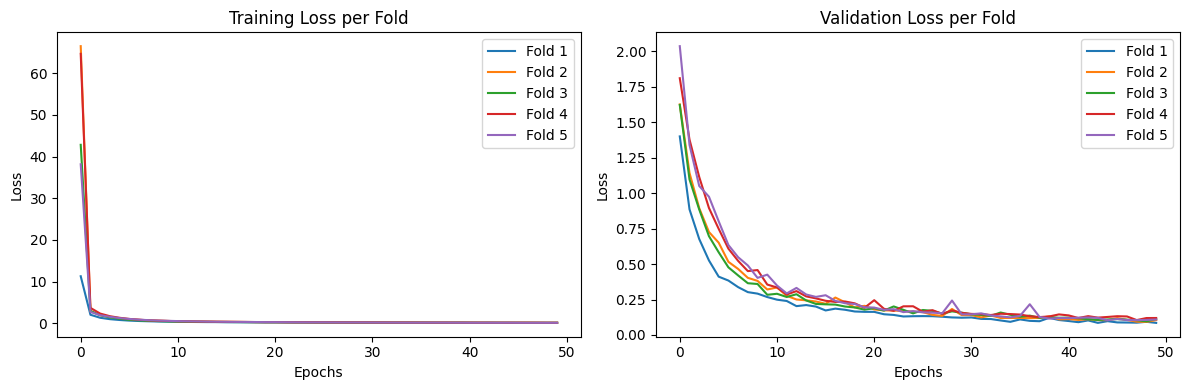

In [18]:
plot_loss_curves(num_epochs, all_loss_train, all_loss_val)

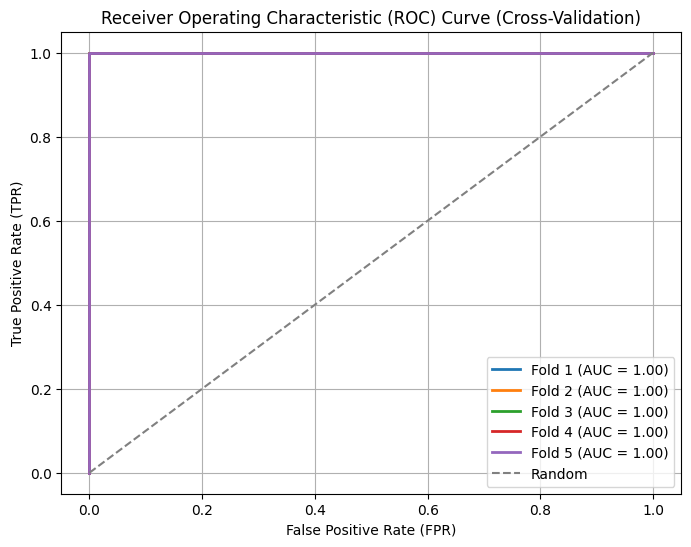

In [19]:
plot_roc_curve(all_probabilities_val, all_ground_truth_val)

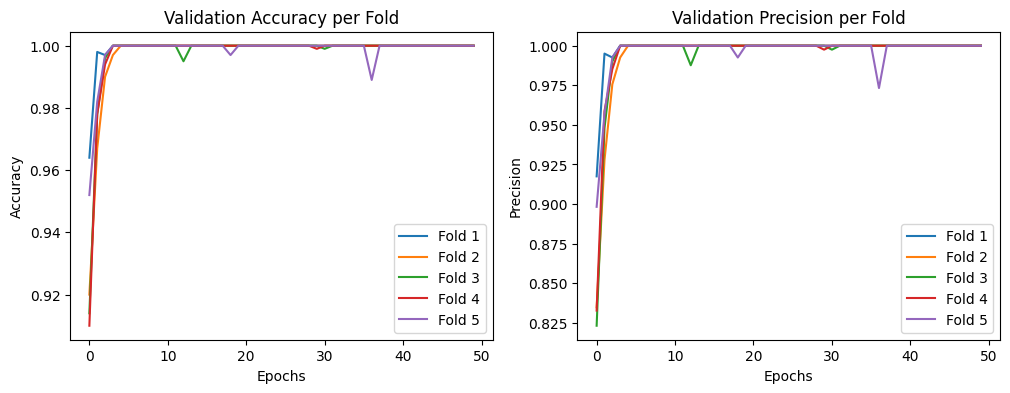

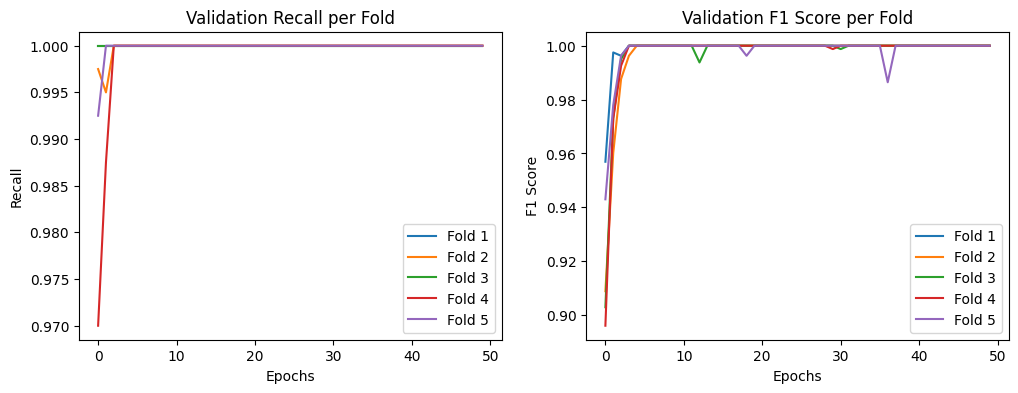

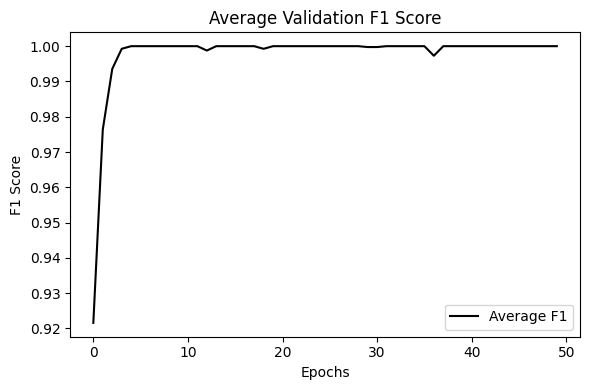

In [20]:
plot_accuracy_precision_recall(num_epochs, all_accuracy_val, all_precision_val, all_recall_val)

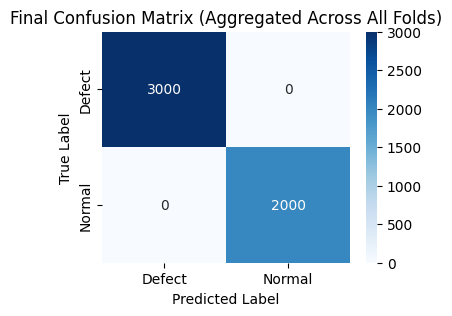


Final Confusion Matrix (Aggregated Across All Folds):
[[3000    0]
 [   0 2000]]

Classification Report (Aggregated Across All Folds):
              precision    recall  f1-score   support

      Defect       1.00      1.00      1.00      3000
      Normal       1.00      1.00      1.00      2000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [21]:
plot_confusion_matrix(all_ground_truth_val, all_predicted_val)

In [38]:
!pip freeze > requirements.txt